In [34]:
# Importations
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import openslide
import torch

from tilingtool.core import histo
from tilingtool.filters.matter_detection import BUNet
from tilingtool.extractors import ResNet50Keras

In [3]:
# Constants
DATA_PATH = '/STORAGE/data/Camelyon_clean/slides'
SAVE_PATH = './tmp/'

In [4]:
# Create dataframe
filenames = os.listdir(DATA_PATH)

df = pd.DataFrame(data=filenames, columns=['filename'])
df['label'] = df.filename.apply(lambda x:1 if x.split('_')[0] == 'Tumor' else 0)
df['test'] = df.filename.apply(lambda x:1 if x.split('_')[0] == 'Test' else 0)
df.head()

,filename,label,test
0,Test_016.tif,0,1
1,Normal_006.tif,0,0
2,Normal_122.tif,0,0
3,Tumor_047.tif,1,0
4,Normal_125.tif,0,0


In [7]:
print('Total number of slides:', len(df))
print('Number of training slides:', len(df[(df.test == 0)]))

df.label.value_counts()

Total number of slides: 399
Number of training slides: 269


0    329
1     70
Name: label, dtype: int64

In [8]:
def display_thumbnails(df, n_cols=5, n_rows=2):
    figsize = (n_cols * 4, n_rows * 4)
    plt.figure(figsize=figsize)

    random_indices = np.random.choice(len(df), n_cols * n_rows, replace=False)
    for i, idx in enumerate(random_indices):
        slide_name = df.filename.iloc[idx]
        slide_path = os.path.join(DATA_PATH, slide_name)
        slide = openslide.OpenSlide(slide_path)
        thumbnail = slide.get_thumbnail(size=(200, 200))

        ax = plt.subplot(n_rows, n_cols, i+1)
        ax.imshow(thumbnail)
        ax.set_title("")
        ax.set_axis_off()

    plt.show()
    
def display_mask(slide, mask):
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    # im_ratio = heatmap.shape[0] / heatmap.shape[1]
    sns.heatmap(mask, ax=ax, square=True, cmap='viridis', cbar_kws={"fraction": 0.03}, cbar=True)
    # im = ax.imshow(heatmap, cmap="viridis")
    # if color_bar:
        # plt.colorbar(im, fraction=0.046*im_ratio, pad=0.04)
    ax.set_axis_off()

Number of slides: 399


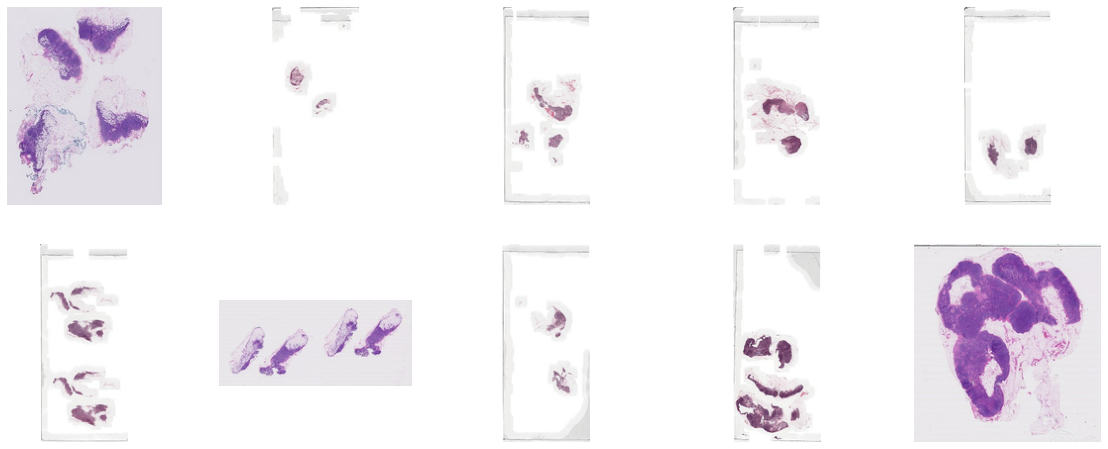

In [9]:
# Data exploration
print('Number of slides:', len(df))

display_thumbnails(df, n_cols=5, n_rows=2)

In [55]:
def load_slide(slide_path):
    slide = openslide.open_slide(slide_path)
    return slide

def display_thumbnail(slide, size=(400, 400)):
    thumbnail = slide.get_thumbnail(size=size)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(thumbnail)
    plt.axis('off')
    plt.show()

In [89]:
data['metadata']['slide_size']

[97792, 221184]

In [130]:
xs, ys = [], []
for m in range(len(features)):
    x, y = int(features[m,1]), int(features[m,2])
    x, y = x/mask.shape[0], y/mask.shape[1]
    x, y = int(x * 97792), int(y * 221184)
    xs.append(x); ys.append(y)

(100000.0, 200000.0)

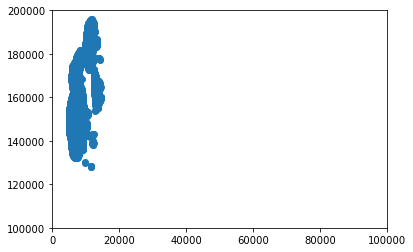

In [142]:
plt.scatter(xs, ys)
plt.xlim(0,100000); plt.ylim(100000, 200000)

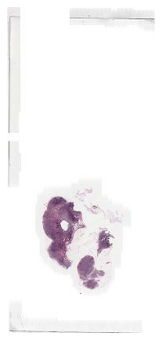

(1000, 1000)


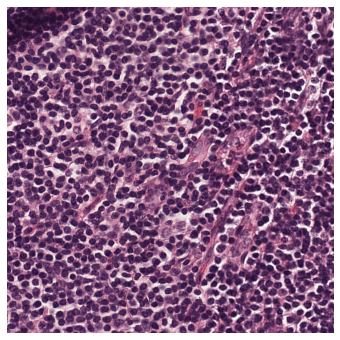

In [121]:
path = '/hdd1/Camelyon/tiling_full/Normal_065.tif'
features = np.load(os.path.join(path, 'features.npy'))
mask = np.load(os.path.join(path, 'mask.npy'))
with open(os.path.join(path, 'tiling_tool_format.json')) as f:
    data = json.load(f)

slide_path = os.path.join(DATA_PATH, 'Normal_065.tif')
slide = load_slide(slide_path)
display_thumbnail(slide)

m = 1000
x, y = int(features[m,1]), int(features[m,2])
x, y = x/mask.shape[0], y/mask.shape[1]
x, y = int(x * 97792), int(y * 221184)

location = (30000, 150000)
#location = (x, y)
level = 0
size = (1000, 1000)

tile = slide.read_region(location, level, size)
print(tile.size)

plt.figure(figsize=(6, 6))
plt.imshow(tile)
plt.axis('off')
plt.show()

In [16]:
data

{'features_path': 'features.npy',
 'mask_path': 'mask.npy',
 'metadata': {'version': '2.0.0',
  'tiling_tool_version': '9.1.0',
  'nb_tiles': 1452,
  'total_number_of_tiles': 1452,
  'sampling_mode': {'mode': 'random', 'seed': 0},
  'matter_detector': {'name': 'BUNet', 'dilatation': 1, 'threshold': 0.6},
  'features_extractor': 'ResNet50Keras',
  'level': 17,
  'tile_size': 224,
  'absolute_tile_size': 448,
  'slide_size': [97792, 221184],
  'tile_mpp': 0.48618799999999995,
  'level_dimensions': {'0': [1, 1],
   '1': [1, 2],
   '2': [2, 4],
   '3': [3, 7],
   '4': [6, 14],
   '5': [12, 27],
   '6': [24, 54],
   '7': [48, 108],
   '8': [96, 216],
   '9': [191, 432],
   '10': [382, 864],
   '11': [764, 1728],
   '12': [1528, 3456],
   '13': [3056, 6912],
   '14': [6112, 13824],
   '15': [12224, 27648],
   '16': [24448, 55296],
   '17': [48896, 110592],
   '18': [97792, 221184]},
  'level_mpp_mapping': {'0': 63725.633535999994,
   '1': 31862.816767999997,
   '2': 15931.408383999998,
   '3

In [14]:
features.shape, mask.shape

((1452, 2051), (1064, 471))

In [10]:
idx = 0

slide_name = df.filename.iloc[idx]
slide_path = os.path.join(DATA_PATH, slide_name)
slide = openslide.OpenSlide(slide_path)

matter_detector = BUNet()
extractor = ResNet50Keras()

mask, features, metadata = histo.extract(slide,
                                         matter_detector,
                                         extractor)

2021-11-26 15:55:26.799 | INFO     | tilingtool.filters.matter_detection.bunet:__init__:42 - Loading BUNet from classic-algo's hub.
/home/rghermi/.conda/envs/histo/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
2021-11-26 15:55:35.189 | INFO     | tilingtool.extractors.resnet50_keras:__init__:37 - Loading ResNet50Keras from classic-algo's hub.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [8]:
# Script - Extract and save masks and features for each slide
for i, row in df.iterrows():
    filename = row.filename
    print(i, filename)
    
    slide_name = filename
    slide_path = os.path.join(DATA_PATH, slide_name)
    slide = openslide.OpenSlide(slide_path)

    #matter_detector = BUNet()
    #extractor = ResNet50Keras()

    #mask, features, metadata = histo.extract(slide,
    #                                         matter_detector,
    #                                         extractor)
    
    
    name = filename.split('.')[0]
    
    mask_name = '_'.join([name, 'mask'])
    mask_name = '.'.join([mask_name, 'npy'])
    mask_path = os.path.join(SAVE_PATH, mask_name)
    
    features_name = '_'.join([name, 'features'])
    features_name = '.'.join([features_name, 'npy'])
    features_path = os.path.join(SAVE_PATH, features_name)
    
    #np.save(mask_path, mask)
    #np.save(features_path, features)
    print(mask_path, features_path)
    break

0 Test_016.tif
./tmp/Test_016_mask.npy ./tmp/Test_016_features.npy
